In [2]:
import pyspark.sql as ps
import pyspark.sql.functions as F
from pyspark.ml.feature import StringIndexer
import pandas
import matplotlib.pyplot as plt
inp_file_path: str = 'file:///D:/MAHE/5thSem/BDA2/data/2019-Sma.csv'
print(inp_file_path)

file:///D:/MAHE/5thSem/BDA2/data/2019-Sma.csv


In [9]:
spark: ps.SparkSession = ps.SparkSession.builder.master("yarn").appName("test").getOrCreate()
raw_data: ps.DataFrame = spark.read.csv(inp_file_path, header=True, inferSchema=True)

In [10]:
raw_data.show(5)
raw_data.summary()

+-------------------+----------+----------+-------------------+--------------------+--------+-------+---------+--------------------+
|         event_time|event_type|product_id|        category_id|       category_code|   brand|  price|  user_id|        user_session|
+-------------------+----------+----------+-------------------+--------------------+--------+-------+---------+--------------------+
|2019-10-01 05:30:00|      view|  44600062|2103807459595387724|                null|shiseido|  35.79|541312140|72d76fde-8bb3-4e0...|
|2019-10-01 05:30:00|      view|   3900821|2053013552326770905|appliances.enviro...|    aqua|   33.2|554748717|9333dfbd-b87a-470...|
|2019-10-01 05:30:01|      view|  17200506|2053013559792632471|furniture.living_...|    null|  543.1|519107250|566511c2-e2e3-422...|
|2019-10-01 05:30:01|      view|   1307067|2053013558920217191|  computers.notebook|  lenovo| 251.74|550050854|7c90fc70-0e80-459...|
|2019-10-01 05:30:04|      view|   1004237|2053013555631882655|electr

DataFrame[summary: string, event_type: string, product_id: string, category_id: string, category_code: string, brand: string, price: string, user_id: string, user_session: string]

In [11]:
str_ind = StringIndexer(inputCols=['event_type', 'category_code'], outputCols=['event_ind', 'category_ind'], handleInvalid='keep')
str_ind = str_ind.fit(raw_data)
eve_dict = {label: ind for ind, label in enumerate(str_ind.labelsArray[0])}
cat_dict = {label: ind for ind, label in enumerate(str_ind.labelsArray[1])}

dataset = str_ind.transform(raw_data)
dataset = dataset.drop(dataset.category_id, dataset.event_type, dataset.category_code). \
    withColumnsRenamed({'event_ind': 'event_type', 'category_ind': 'category_code'}). \
    withColumn('event_time', F.to_date(dataset.event_time))

In [12]:
print(eve_dict)
print(cat_dict)
dataset.show()
print(dataset.summary())

{'view': 0, 'purchase': 1}
{'electronics.smartphone': 0, 'appliances.environment.water_heater': 1, 'computers.notebook': 2, 'apparel.shoes.keds': 3, 'electronics.audio.headphone': 4, 'appliances.environment.vacuum': 5, 'appliances.kitchen.mixer': 6, 'furniture.bedroom.bed': 7, 'apparel.shoes': 8, 'appliances.kitchen.microwave': 9, 'appliances.kitchen.washer': 10, 'computers.desktop': 11, 'electronics.video.tv': 12, 'appliances.environment.air_heater': 13, 'appliances.kitchen.refrigerators': 14, 'computers.peripherals.monitor': 15, 'construction.tools.pump': 16, 'furniture.living_room.sofa': 17}
+----------+----------+--------+-------+---------+--------------------+----------+-------------+
|event_time|product_id|   brand|  price|  user_id|        user_session|event_type|category_code|
+----------+----------+--------+-------+---------+--------------------+----------+-------------+
|2019-10-01|  44600062|shiseido|  35.79|541312140|72d76fde-8bb3-4e0...|       0.0|         18.0|
|2019-10-0

In [27]:
visits = dataset.groupBy(F.to_date(dataset.event_time).alias("event_time")). \
    agg(F.count_distinct("user_session").alias("number_of_daily_visits"),
        F.count_distinct("user_id").alias("number_of_daily_visitors"))

sales = dataset.where(dataset.event_type == eve_dict['purchase']). \
    withColumn("event_time", F.to_date(dataset.event_time)). \
    groupBy("event_time"). \
    agg(F.count("event_type").alias("number_of_daily_sales"),
        F.sum("price").alias("total_daily_sales"))

daily = visits.join(sales, on=["event_time"], how="left"). \
    withColumn("conversion_rate", F.col('number_of_daily_sales') / F.col('number_of_daily_visits'))

daily.show()

+----------+----------------------+------------------------+---------------------+-----------------+--------------------+
|event_time|number_of_daily_visits|number_of_daily_visitors|number_of_daily_sales|total_daily_sales|     conversion_rate|
+----------+----------------------+------------------------+---------------------+-----------------+--------------------+
|2019-10-01|                    55|                      54|                    4|          2933.28| 0.07272727272727272|
|2019-10-02|                    22|                      22|                    1|           122.18|0.045454545454545456|
+----------+----------------------+------------------------+---------------------+-----------------+--------------------+



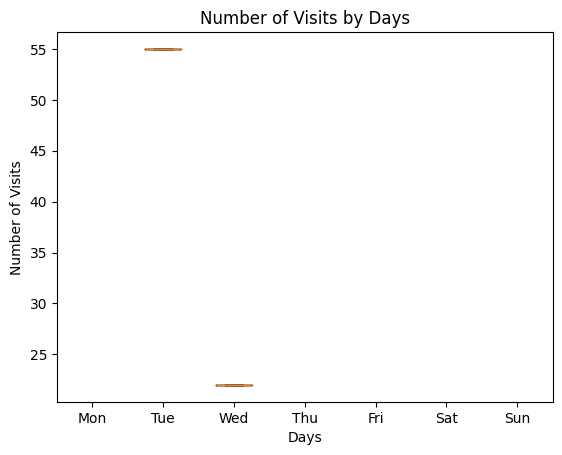

In [32]:
daily_pd = daily.withColumn('day', F.date_format('event_time', 'E')). \
    select('day', 'number_of_daily_visits'). \
    toPandas()
day_order = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
data_for_plot = [daily_pd[daily_pd['day'] == d]['number_of_daily_visits'] for d in day_order]

plt.boxplot(data_for_plot, tick_labels=day_order)
plt.title('Number of Visits by Days')
plt.ylabel('Number of Visits')
plt.xlabel('Days')
plt.show()

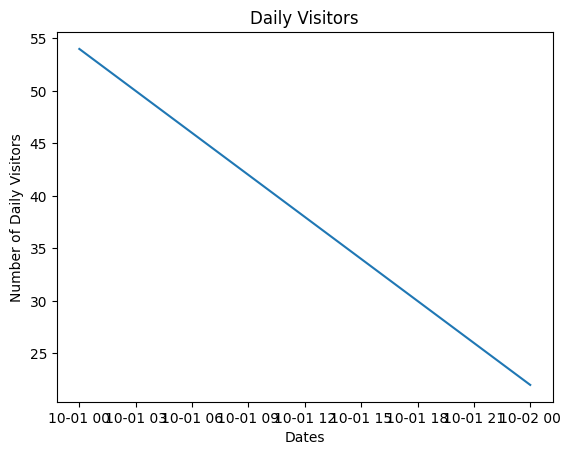

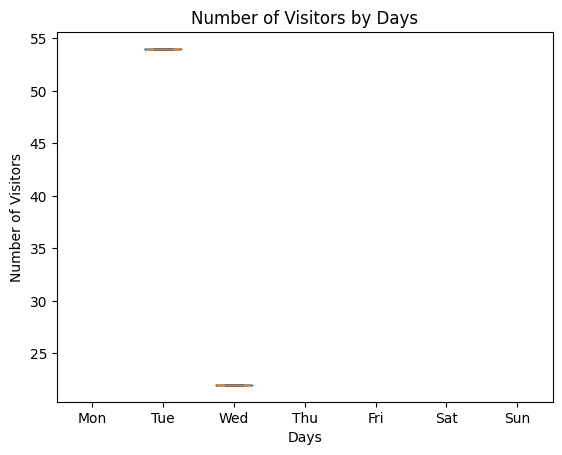

In [33]:
daily_pd = daily.withColumn('day', F.date_format('event_time', 'E')). \
select('event_time', 'day', 'number_of_daily_visitors'). \
toPandas()

plt.plot(daily_pd['event_time'], daily_pd['number_of_daily_visitors'])
plt.title('Daily Visitors')
plt.ylabel('Number of Daily Visitors')
plt.xlabel('Dates')
plt.show()

data_for_plot = [daily_pd[daily_pd['day'] == d]['number_of_daily_visitors'] for d in day_order]

plt.boxplot(data_for_plot, tick_labels=day_order)
plt.title('Number of Visitors by Days')
plt.ylabel('Number of Visitors')
plt.xlabel('Days')
plt.show()

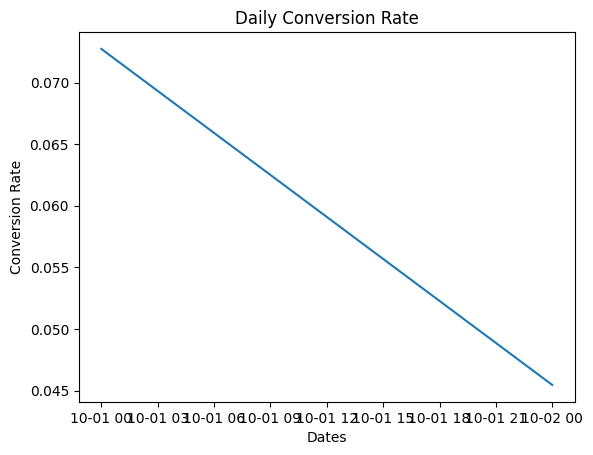

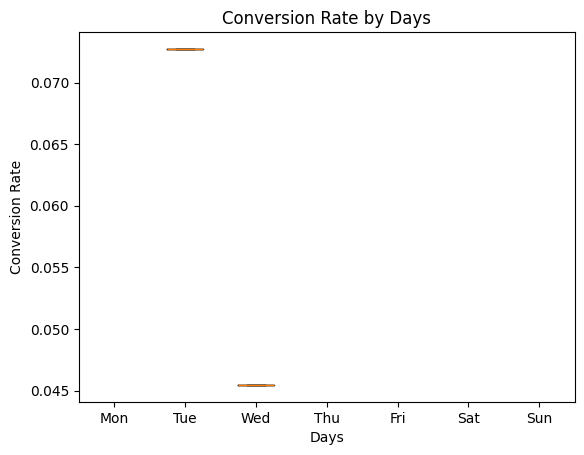

In [36]:
daily_pd = daily.withColumn('day', F.date_format('event_time', 'E')). \
    select('event_time', 'day', 'conversion_rate'). \
    toPandas()

plt.plot(daily_pd['event_time'], daily_pd['conversion_rate'])
plt.title('Daily Conversion Rate')
plt.ylabel('Conversion Rate')
plt.xlabel('Dates')
plt.show()

data_for_plot = [daily_pd[daily_pd['day'] == d]['conversion_rate'] for d in day_order]

plt.boxplot(data_for_plot, tick_labels=day_order)
plt.title('Conversion Rate by Days')
plt.ylabel('Conversion Rate')
plt.xlabel('Days')
plt.show()

In [83]:
customer_table = dataset.where(dataset.event_type == eve_dict['purchase']). \
    groupBy('user_id'). \
    agg(F.count('user_id').alias('number_of_purchases'),
        F.sum('price').alias('total_sales'))
customer_table.show()

+---------+-------------------+-----------+
|  user_id|number_of_purchases|total_sales|
+---------+-------------------+-----------+
|537918940|                  1|     566.01|
|550050854|                  1|     580.89|
|535871217|                  1|    1747.79|
|554748717|                  1|     122.18|
|544648245|                  1|      38.59|
+---------+-------------------+-----------+



In [84]:
customers_who_purchased = customer_table.select(customer_table.user_id). \
    dropDuplicates(). \
    count()

repeat_customers = customer_table.where('number_of_purchases > 1'). \
    select(customer_table.user_id). \
    dropDuplicates(). \
    count()
    
print(f'There are {customers_who_purchased} customers, who purchased in October, out of these {repeat_customers} are repeat customers.\n')

print('Distribution of Customer by Number of Purchases:')
customer_table.groupBy(customer_table.number_of_purchases).count().show(10)

There are 5 customers, who purchased in October, out of these 0 are repeat customers.

Distribution of Customer by Number of Purchases:
+-------------------+-----+
|number_of_purchases|count|
+-------------------+-----+
|                  1|    5|
+-------------------+-----+



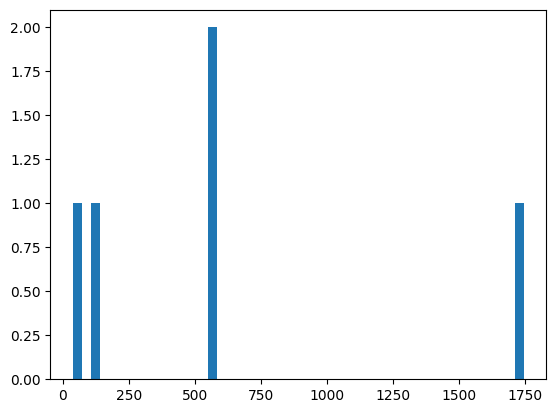

In [85]:
sales_thresholds = customer_table.approxQuantile("total_sales", [0.01, 0.95], 0.0)
customers_filtered = customer_table.filter((customer_table.total_sales >= sales_thresholds[0]) &
                                           (customer_table.total_sales <= sales_thresholds[1]))

plt.hist(customers_filtered.select(customers_filtered.total_sales).toPandas(), 50)
plt.show()

In [86]:
top10p_sales = customer_table.approxQuantile("total_sales", [0.9], 0.0)[0]
top10p_customers = customer_table.filter(F.col("total_sales") >= top10p_sales)
regular_customers = customer_table.filter(F.col("total_sales") < top10p_sales)

print(r'Top 10% customers Purchase Amount-Descriptive Statistics')
top10p_customers.select(top10p_customers.total_sales).summary().show()
print(r'Total sales of top 10% customers:')
top10p_customers.agg(F.sum(top10p_customers.total_sales)).show()

Top 10% customers Purchase Amount-Descriptive Statistics
+-------+-----------+
|summary|total_sales|
+-------+-----------+
|  count|          1|
|   mean|    1747.79|
| stddev|       null|
|    min|    1747.79|
|    25%|    1747.79|
|    50%|    1747.79|
|    75%|    1747.79|
|    max|    1747.79|
+-------+-----------+

Total sales of top 10% customers:
+----------------+
|sum(total_sales)|
+----------------+
|         1747.79|
+----------------+



In [87]:
print(r'Bottom 90% customers Purchase Amount-Descriptive Statistics')
regular_customers.select(regular_customers.total_sales).summary().show()
print(r'Total sales of bottom 90% customers:')
regular_customers.agg(F.sum(regular_customers.total_sales)).show()

Bottom 90% customers Purchase Amount-Descriptive Statistics
+-------+-----------------+
|summary|      total_sales|
+-------+-----------------+
|  count|                4|
|   mean|         326.9175|
| stddev|286.7736886321106|
|    min|            38.59|
|    25%|            38.59|
|    50%|           122.18|
|    75%|           566.01|
|    max|           580.89|
+-------+-----------------+

Total sales of bottom 90% customers:
+----------------+
|sum(total_sales)|
+----------------+
|         1307.67|
+----------------+



In [88]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline

In [89]:
k_mod = Pipeline(stages=[VectorAssembler(inputCols=['number_of_purchases', 'total_sales'], outputCol='features'),
                         KMeans(k=3, predictionCol='cluster')])

k_mod = k_mod.fit(regular_customers)
regular_customers = k_mod.transform(regular_customers)

+-------+----------------+----------------+----------------+----------------+------------------------+
|cluster|sum(total_sales)|max(total_sales)|min(total_sales)|avg(total_sales)|stddev_samp(total_sales)|
+-------+----------------+----------------+----------------+----------------+------------------------+
|      1|           38.59|           38.59|           38.59|           38.59|                    null|
|      2|          122.18|          122.18|          122.18|          122.18|                    null|
|      0|          1146.9|          580.89|          566.01|          573.45|      10.521748904055825|
+-------+----------------+----------------+----------------+----------------+------------------------+



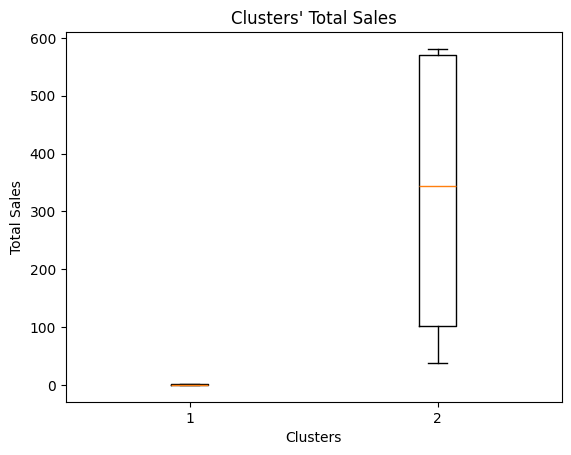

,cluster,total_sales
0,0,566.01
1,0,580.89
2,2,122.18
3,1,38.59


In [ ]:
customer_table_joined = customer_table.join(regular_customers.select('user_id', 'cluster'), 'user_id')

customer_table_joined.groupBy(customer_table_joined.cluster).agg(F.sum('total_sales'),
                                                                 F.max('total_sales'),
                                                                 F.min('total_sales'),
                                                                 F.avg('total_sales'),
                                                                 F.stddev('total_sales')).show()

plt.boxplot(customer_table_joined.select('cluster', 'total_sales').toPandas())
plt.xlabel('Clusters')
plt.ylabel('Total Sales')
plt.title("Clusters' Total Sales")
plt.show()

In [109]:
spark.stop()